"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9


import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [3]:
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import arviz as az
import pandas as pd
import seaborn as sns

In [4]:
# np.__config__.show()

In [5]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

[ 37 116]
[  0  37 116 200]
(5, 3)
(5, 200)


Text(0, 0.5, 'Neuron # (Channels)')

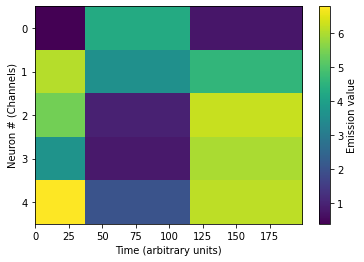

In [50]:
# Some poisson spiking
length = 200
states = 3
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

nrns = 5
lambda_multipliers = np.random.random(states) * 10
true_lambda = np.random.random((nrns,states))
true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]

print(true_tau)
print(state_inds)
print(true_lambda.shape)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
plt.imshow(true_r,aspect='auto', interpolation='nearest');plt.colorbar(label = 'Emission value')
plt.xlabel('Time (arbitrary units)')
plt.ylabel("Neuron # (Channels)")

In [51]:
# Max number of states
templates = 3

with pm.Model() as model:
    
    # =====================
    # Changepoint Variables
    # =====================
    a = pm.HalfCauchy('a_tau', 3., shape = templates - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = templates - 1)
    
    even_switches = np.linspace(0,1,templates+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (templates-1)).sort(axis=-1)
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Weight stack to assign lambda's to point in time
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    # =====================
    # Projection Matrix
    # =====================
    # Data = neurons x time
    # Template = dims x time
    # Projection mat = neurons x dims
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 10, shape = (nrns, templates))
    
    projected_dat = pm.Deterministic('proj_dat', tt.dot(proj_mat,weight_stack))
    
    # =====================
    # Likelihood
    # =====================
    obs = pm.Normal('obs', mu = projected_dat, sigma = 10, observed = true_r)

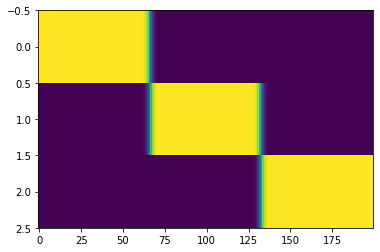

In [52]:
plt.imshow(weight_stack.tag.test_value, aspect='auto', interpolation='nearest')

In [53]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 5000)

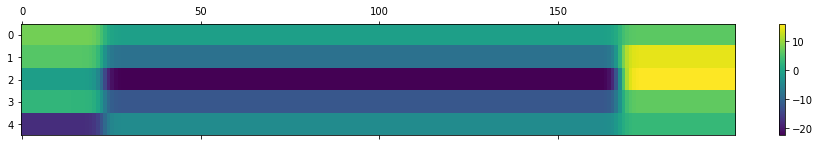

In [54]:
plt.matshow(spp['proj_dat'][0], aspect='auto');plt.colorbar()

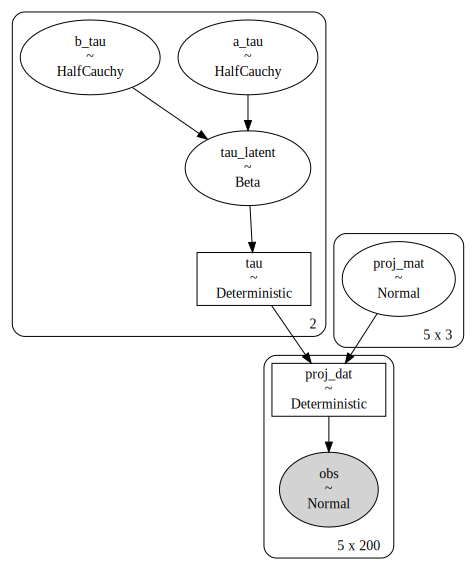

In [55]:
pm.model_to_graphviz(dpp_model)

In [56]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proj_mat, tau_latent, b_tau, a_tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
There were 941 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4947414396925432, but should be close to 0.8. Try to increase the number of tuning steps.
There were 840 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49476303160990004, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


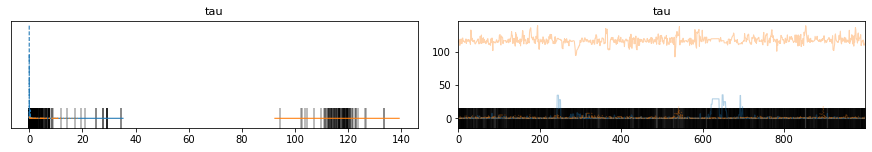

In [57]:
with model:
    pm.traceplot(trace, var_names = ['tau']);

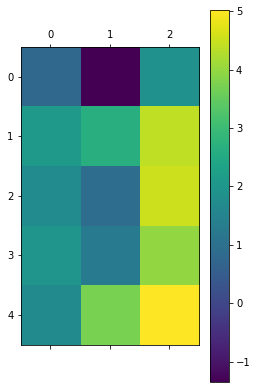

In [61]:
plt.matshow(trace['proj_mat'].mean(axis=0)); plt.colorbar()

In [58]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples = 2000)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


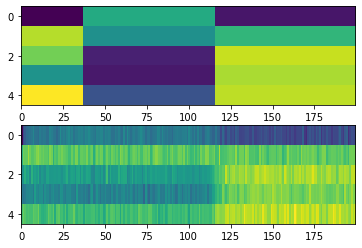

In [59]:
fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r, interpolation = 'nearest', aspect = 'auto')
ax[1].imshow(ppc['obs'].mean(axis=0), interpolation = 'nearest', aspect = 'auto')